In [171]:
! pip install torchaudio
! pip install librosa
! pip install umap
! pip install umap-learn
! pip install matplotlib

import torchaudio 
import torch
import os
import librosa
import umap
import umap.umap_ as umap
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [172]:
import pandas as pd

In [173]:
csv = 'archive/bird_songs_metadata.csv'
df = pd.read_csv(csv)

genuses = df.genus.unique()
df = pd.concat([df[df.genus==s].head(25) for s in genuses], ignore_index=True)
paths = df.filename

In [174]:
waveforms = []
path = 'archive/wavfiles'

for filepath in paths:
    path_ = path + '/' + filepath
    wave, sample_rate = librosa.load(path_) # 22050 
    waveforms.append(torch.Tensor(wave))

In [175]:
input_size = waveforms[0].shape[0]
input_size

66150

In [176]:
set(genuses)

{'Cardinalis', 'Melospiza', 'Mimus', 'Thryomanes', 'Turdus'}

In [177]:
len(waveforms)

125

In [178]:
import numpy as np

def plot_embs(embs, title = "", do_lfcc=False):
    if do_lfcc == True:
        embs = [make_embs(audio) for audio in embs]
    embs = umap.UMAP().fit_transform(torch.stack(embs))

    colors = ['red' if g == 'Cardinalis' 
          else 'brown' if g == 'Melospiza' 
          else 'yellow' if g == 'Mimus' 
          else 'blue' if g == 'Thryomanes'
          else 'black' # if g == 'Turdus'
          for g in df.genus]
    
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.scatter(embs[:, 0], embs[:, 1], color=colors)
    plt.show()
    return embs

In [179]:
def make_embs(audio: torch.Tensor) -> torch.Tensor:
    transform = torchaudio.transforms.LFCC(
         sample_rate=sample_rate
    )
    lfcc = transform(audio)
    
    mels = lfcc.mean(dim=1)
    return mels

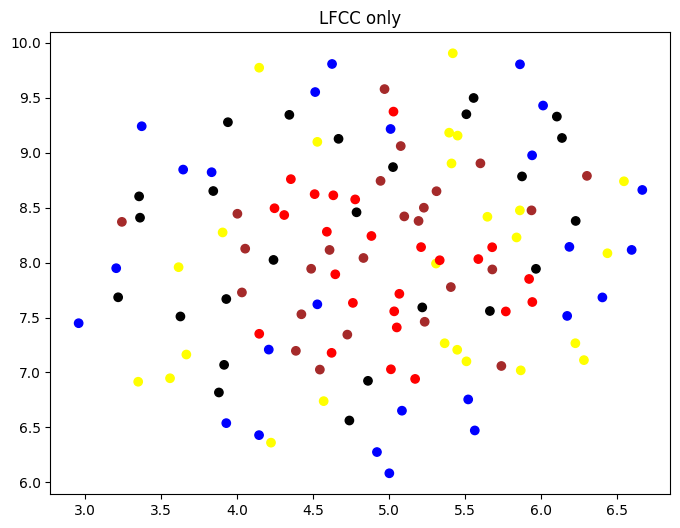

In [180]:
_ = plot_embs(waveforms, "LFCC only")

In [181]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_size, 1323),
            torch.nn.ReLU(),
            torch.nn.Linear(1323, 147),
            torch.nn.ReLU(),
            torch.nn.Linear(147, 49),
            torch.nn.ReLU(),
            torch.nn.Linear(49, 7)
        )
         
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(7, 49),
            torch.nn.ReLU(),
            torch.nn.Linear(49, 147),
            torch.nn.ReLU(),
            torch.nn.Linear(147, 1323),
            torch.nn.ReLU(),
            torch.nn.Linear(1323, input_size)
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [189]:
embs = [make_embs(audio) for audio in waveforms]
    
model = AE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

epochs = 3

losses = []
reconstructed_by_epoch = []


for epoch in range(epochs):
    reconstructed = []
    loss_sum = 0
    for audio in waveforms:
        optimizer.zero_grad()
        res = model(audio)
        loss = loss_fn(res, audio)
        loss_sum += loss
        
        loss.backward()
        optimizer.step()

        reconstructed.append(res)
    reconstructed_by_epoch.append(reconstructed)

    print("Epoch %d: Loss: %.4f" % (epoch, loss_sum / len(waveforms)))

Epoch 0: Loss: 0.0238
Epoch 1: Loss: 0.0231
Epoch 2: Loss: 0.0231


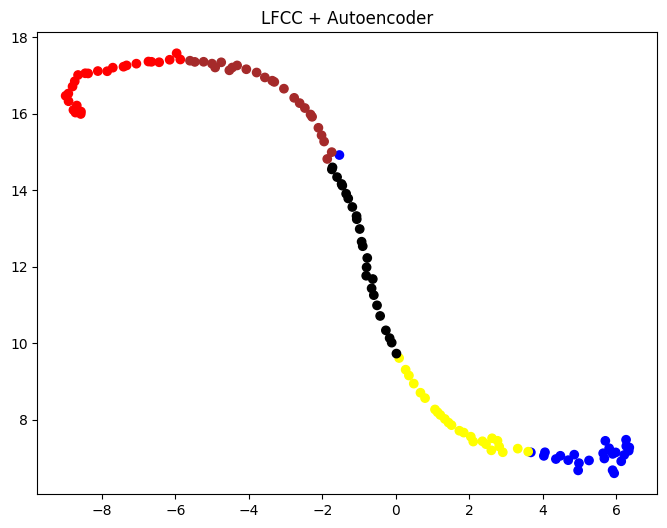

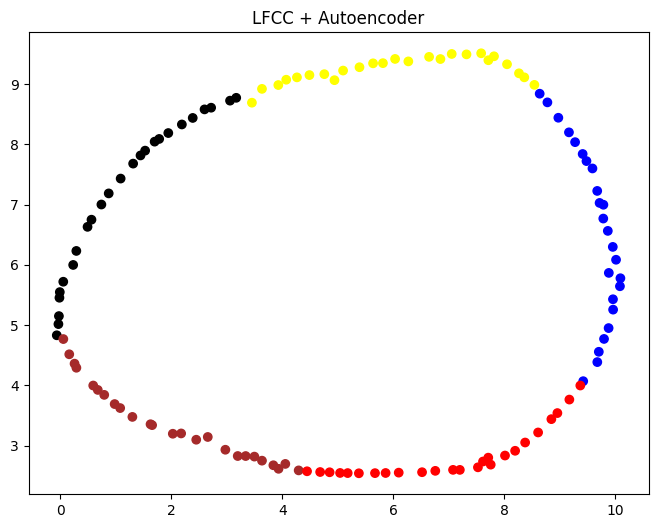

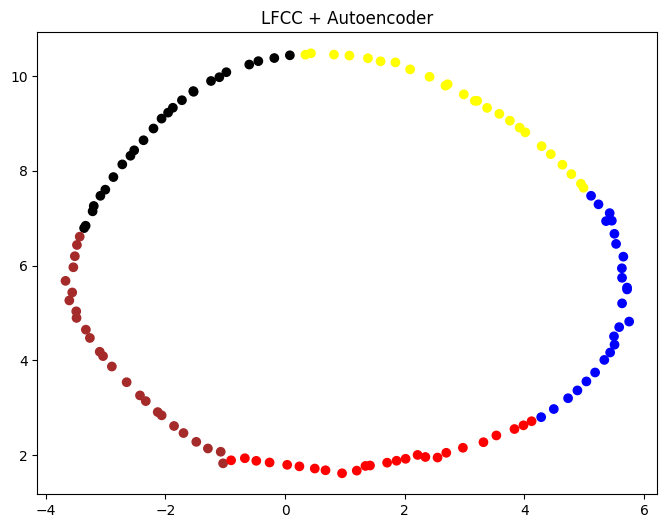

In [190]:
embs = []
points_to_count_dist = []
for reconstructed in reconstructed_by_epoch:
    for e in reconstructed:
        embs.append(e.data)
    points_to_count_dist.append(plot_embs(embs, "LFCC + Autoencoder", False))
    embs = []

In [191]:
# listen to 'Cardinalis' and 'Melospiza'

import IPython
from random import randint

cardinalis = df.loc[df['genus'] == 'Cardinalis']['filename']
to_display1 = cardinalis.values[randint(0, len(cardinalis))]
IPython.display.Audio(filename ="./archive/wavfiles/" + to_display1, rate=sample_rate)

In [192]:
melospiza = df.loc[df['genus'] == 'Melospiza']['filename']
to_display2 = melospiza.values[randint(0, len(melospiza))]
IPython.display.Audio(filename ="./archive/wavfiles/" + to_display2, rate=sample_rate)

In [193]:
import math

def find_closest_points(dots):
    n = len(dots)
    min_d = 1e1000
    closest_indexes = (0, 0)
    for i in range(n):
        for j in range(i+1, n):
            if df.iloc[i].genus != df.iloc[j].genus:
                a = dots[i][0]
                b = dots[i][1]
                c = dots[j][0]
                d = dots[j][1]
                d = math.sqrt(pow(c-a, 2) + pow(d-b, 2))

                if d < min_d:
                    min_d = d
                    closest_indexes = (i, j)
    return closest_indexes
(i1, i2) = find_closest_points(points_to_count_dist[0])

In [194]:
print(df[df.filename==paths[i1]].genus)
IPython.display.Audio(f'./archive/wavfiles/{paths[i1]}')

24    Thryomanes
Name: genus, dtype: object


In [195]:
print(df[df.filename==paths[i2]].genus)
IPython.display.Audio(f'./archive/wavfiles/{paths[i2]}')

25    Mimus
Name: genus, dtype: object
